In [1]:
import os
import numpy as np
import matplotlib
import pandas as pd
import json
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import wandb

In [176]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# Make baselines training curves

## Gather data of baselines from WandB

In [330]:
project='Case14_SurveyPaperBase'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperBase
Matching runs: 15
Found 15 runs with env_config.action_space='medha'


In [334]:
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        if (run.config.get('num_sgd_iter') == 15) and not run.config.get('opponent') : # Incorrect config.
            continue
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        metrics_df['name'] = "PPO*" if run.config.get('opponent') else "PPO"
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [335]:
df_base = make_df_metrics(filtered_runs)
df_base

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name,mean_disconnect_count
0,206,1.000000,0,2.000000,206,3.930591e+04,0.000000,1115,PPO*,NaN
1,177,1.000000,0,2.000000,177,4.104501e+04,0.000000,2197,PPO*,NaN
2,227,1.000000,0,3.000000,227,4.038289e+04,0.000000,3281,PPO*,NaN
3,331,2.000000,0,3.000000,331,5.663826e+04,0.000000,4341,PPO*,NaN
4,284,1.000000,0,3.000000,284,7.920459e+04,0.000000,5381,PPO*,NaN
...,...,...,...,...,...,...,...,...,...,...
922,6713,0.000000,0,7.062500,6713,4.991212e+06,1.943750,95609,PPO,0.0
923,7458,0.000000,0,4.128906,7458,2.986585e+06,1.054688,96666,PPO,0.0
924,6812,0.000000,0,5.489583,6812,5.170838e+06,1.286458,97720,PPO,0.0
925,7065,0.005208,0,5.588542,7065,4.241171e+06,1.208333,98793,PPO,0.0


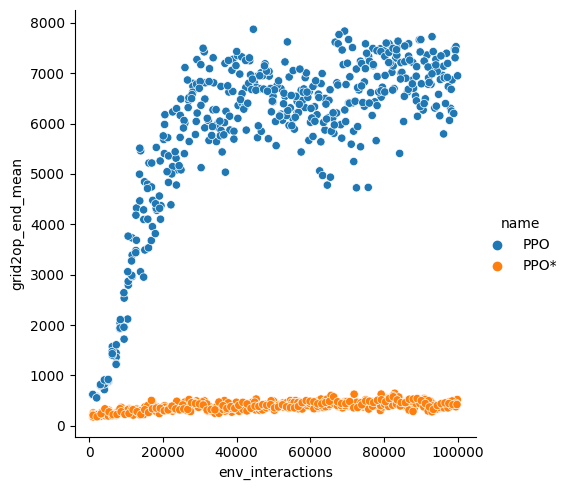

In [74]:
sns.relplot(x="env_interactions", y="grid2op_end_mean", hue="name", data=df)
plt.show()

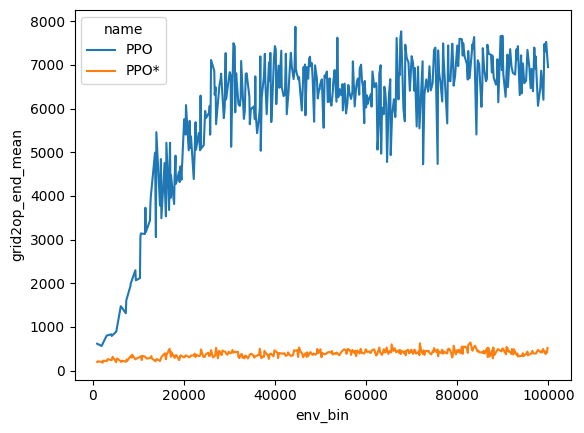

In [72]:
sns.lineplot(x="env_bin", y="grid2op_end_mean", hue="name", data=df_smoothed)
plt.show()

## make the plot

In [237]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_training_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'grid2op_end_mean': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="env_interactions",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Time steps survived', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

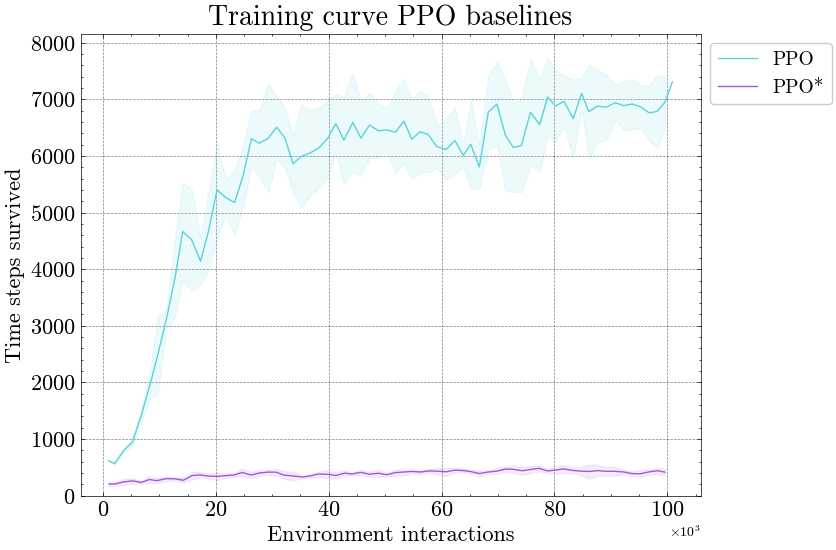

In [336]:
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))
plt = make_training_curve(df_base, header="Training curve PPO baselines", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_New.svg'))

In [332]:
project='Case14_Opponent'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs_opp = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs_opp)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs_opp = [run for run in runs_opp if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs_opp)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_Opponent
Matching runs: 10
Found 5 runs with env_config.action_space='medha'


In [138]:
df_opp = make_df_metrics(filtered_runs_opp)
df_opp

,mean_reconnect_count,mean_interact_count,grid2op_end_std,mean_active_dn_count,grid2op_end_mean,corrected_ep_len_mean,mean_reset_count,env_interactions,name
0,1,2,37271.248748,0,173,173,0,1137,PPO*
1,1,2,55624.774760,0,226,226,0,2311,PPO*
2,1,2,68550.918208,0,262,262,0,3398,PPO*
3,2,3,64223.592683,0,315,315,0,4454,PPO*
4,1,3,63268.001084,0,271,271,0,5534,PPO*
...,...,...,...,...,...,...,...,...,...
2322,3,4,85384.910593,0,459,459,0,494872,PPO*
2323,2,4,94762.342045,1,407,407,0,495905,PPO*
2324,3,4,108076.683541,0,450,450,0,496957,PPO*
2325,3,4,106595.149954,0,449,449,0,498040,PPO*


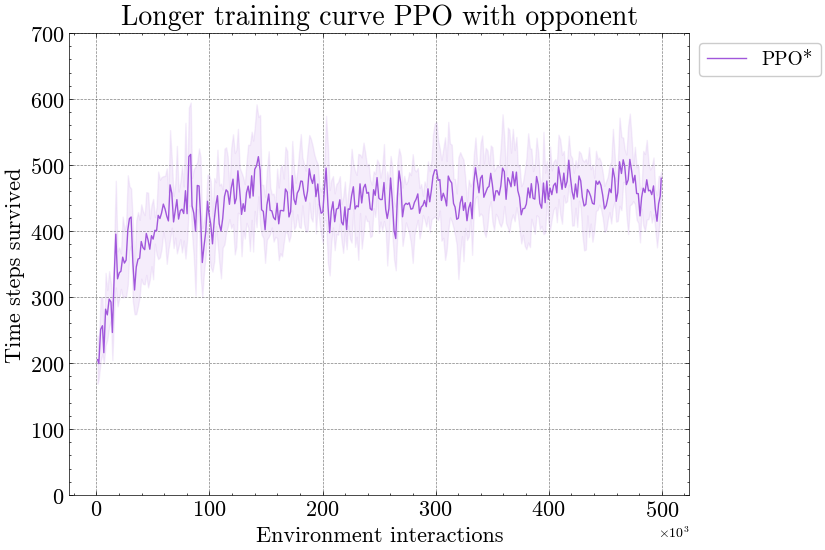

In [165]:
plt = make_training_curve(df_opp, header="Longer training curve PPO with opponent", max_env_steps=600, palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_OppLong.svg'))

In [294]:
def make_color_dict(all_names, baseline_name, base_color = (0.33999999999999997, 0.8287999999999999, 0.86)):
    pos_base = np.nonzero(all_names==baseline_name)[0][0]
    palette = sns.color_palette("hls", len(all_names))
    if (0.33999999999999997, 0.8287999999999999, 0.86) in palette:
        color_pos = palette.index(base_color)
    else:
        color_pos = len(all_names)-1
        palette[color_pos] = (0.33999999999999997, 0.8287999999999999, 0.86)
    order_names = np.roll(all_names, color_pos-pos_base)
    ordered_palette = dict(zip(order_names, palette))
    return ordered_palette

# Action spaces experiments

In [341]:
project='Case14_SurvPapAct'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") in ["assym", "medha", "tennet", "d3qn2022"]]

print(f"Found {len(filtered_runs)} runs satisfying condition")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurvPapAct
Matching runs: 55
Found 50 runs satisfying condition


In [342]:
# Adjust function to include action space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = PPO(*) + action_space
        if run.config.get("env_config", {}).get("action_space") == "assym":
            action_space = "$\mathcal{A}_{sym}$"  
        elif run.config.get("env_config", {}).get("action_space") == "medha":
            action_space = "$\mathcal{A}_{n-0}$"  
        elif run.config.get("env_config", {}).get("action_space") == "tennet":
            action_space = "$\mathcal{A}_{n-1}$"
        elif run.config.get("env_config", {}).get("action_space") == "d3qn2022":
            action_space = "$\mathcal{A}_{d3qn}$"  
        else:
            action_space = ""
        metrics_df['name'] = action_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [343]:
runs_NoOpp = [run for run in runs if not run.config.get('opponent')]
df_act = make_df_metrics(runs_NoOpp)
df_act

,mean_reset_count,mean_reconnect_count,grid2op_end_std,grid2op_end_mean,corrected_ep_len_mean,mean_active_dn_count,mean_interact_count,env_interactions,name,mean_disconnect_count
0,0,0.000000,5.129453e+04,605,605,0.000000,3.000000,1063,$\mathcal{A}_{n-1}$,NaN
1,0,0.000000,4.512383e+04,604,604,0.000000,3.000000,2128,$\mathcal{A}_{n-1}$,NaN
2,0,0.000000,5.890376e+05,785,785,0.000000,4.000000,3176,$\mathcal{A}_{n-1}$,NaN
3,0,0.000000,9.543076e+04,653,653,0.000000,4.000000,4232,$\mathcal{A}_{n-1}$,NaN
4,0,0.000000,3.642673e+05,825,825,0.000000,5.000000,5281,$\mathcal{A}_{n-1}$,NaN
...,...,...,...,...,...,...,...,...,...,...
3404,0,0.008299,4.985589e+06,6723,6723,0.419087,4.377593,95176,$\mathcal{A}_{sym}$,0.0
3405,0,0.000000,5.084663e+06,6716,6716,0.450000,4.483333,96252,$\mathcal{A}_{sym}$,0.0
3406,0,0.000000,2.867251e+06,7349,7349,0.640000,4.631111,97294,$\mathcal{A}_{sym}$,0.0
3407,0,0.000000,2.097858e+06,7579,7579,0.354167,3.760417,98377,$\mathcal{A}_{sym}$,0.0


In [344]:
df_act['name'].unique()

array(['$\\mathcal{A}_{n-1}$', '$\\mathcal{A}_{sym}$',
       '$\\mathcal{A}_{d3qn}$', '', '$\\mathcal{A}_{n-0}$'], dtype=object)

In [345]:
df_act = df_act[df_act['name']!=""]
df_act['name'].unique()

array(['$\\mathcal{A}_{n-1}$', '$\\mathcal{A}_{sym}$',
       '$\\mathcal{A}_{d3qn}$', '$\\mathcal{A}_{n-0}$'], dtype=object)

/var/folders/cf/czcpttnj1r3_8sqyc59jyr3r0000gn/T/ipykernel_2798/4095040832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width


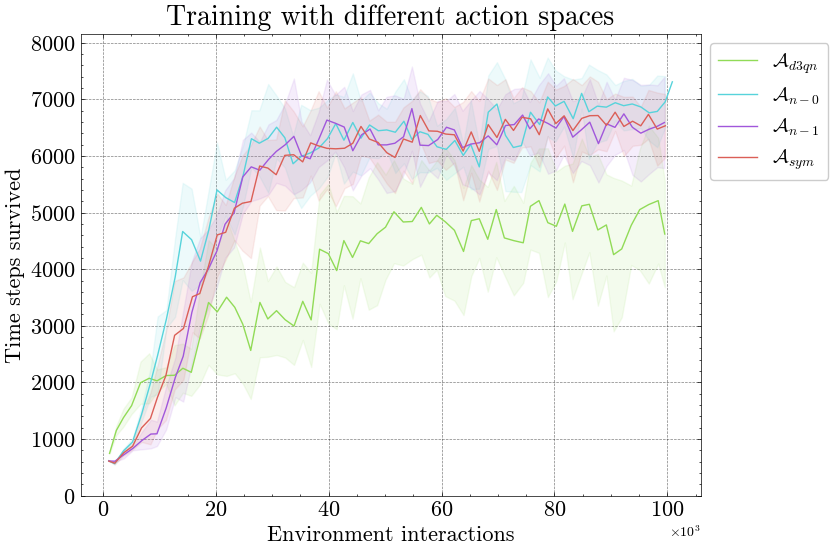

In [346]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_act['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='$\\mathcal{A}_{n-0}$')

# plot 
plt = make_training_curve(df_act, header="Training with different action spaces", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces.svg'))

In [186]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_act_opp = make_df_metrics(runs_Opp)
df_act_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name
0,206,1,0,2,206,39305.914916,0,1115,$\mathcal{A}_{n-0}$
1,177,1,0,2,177,41045.014405,0,2197,$\mathcal{A}_{n-0}$
2,227,1,0,3,227,40382.894081,0,3281,$\mathcal{A}_{n-0}$
3,331,2,0,3,331,56638.261145,0,4341,$\mathcal{A}_{n-0}$
4,284,1,0,3,284,79204.594805,0,5381,$\mathcal{A}_{n-0}$
...,...,...,...,...,...,...,...,...,...
1793,582,3,0,18,582,579028.377100,11,94123,$\mathcal{A}_{d3qn}$
1794,574,3,0,20,574,234329.973900,13,95475,$\mathcal{A}_{d3qn}$
1795,639,4,0,23,639,85011.647500,14,96748,$\mathcal{A}_{d3qn}$
1796,698,4,0,25,698,105650.232400,13,98017,$\mathcal{A}_{d3qn}$


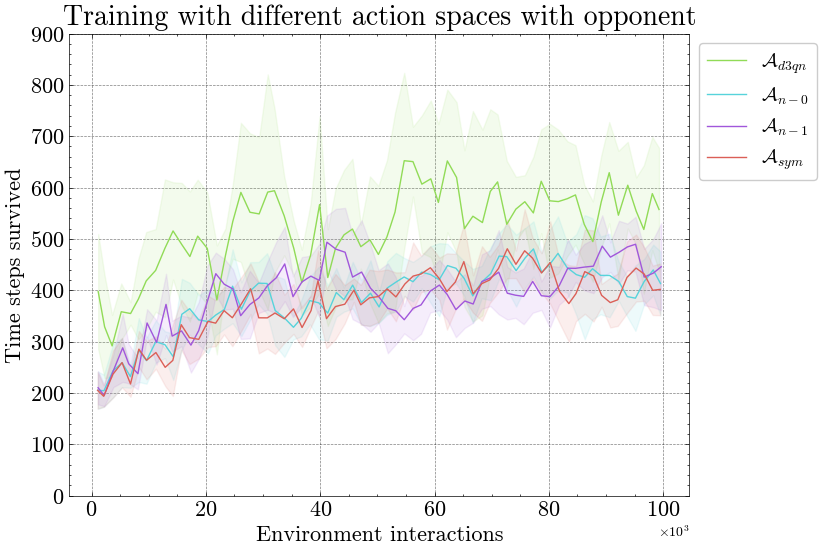

In [239]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_act_opp, header="Training with different action spaces with opponent", palette=fixed_palette, max_env_steps=800)
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces_Opp.svg'))

# Observation spaces experiments

In [347]:
project='Case14_SurveyPaperObs'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperObs
Matching runs: 65


In [348]:
# Adjust function to include observation space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = observation_space
        if run.config.get("env_config", {}).get("g2op_input") == "all":
            obs_space = "Complete"   
        elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
            obs_space = "Line loads"   
        elif run.config.get("env_config", {}).get("n_history") == 6:
            obs_space = "History" 
        elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
            obs_space = "Danger"
        elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "Baseline" 
        elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "D3QN_2022" 
        else:
            obs_space = ""
        metrics_df['name'] = obs_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [349]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_obs = make_df_metrics(runs_NoOpp)
df_obs

,mean_interact_count,grid2op_end_std,mean_reset_count,mean_active_dn_count,grid2op_end_mean,mean_reconnect_count,corrected_ep_len_mean,mean_disconnect_count,env_interactions,name
0,2.917614,4.892728e+04,0,0.173295,614,0.000000,614,0,1027,Baseline
1,2.972452,2.356962e+05,0,0.181818,590,0.013774,590,0,2106,Baseline
2,3.062500,3.257949e+05,0,0.273810,804,0.000000,804,0,3135,Baseline
3,3.559211,5.922907e+05,0,0.296053,800,0.000000,800,0,4217,Baseline
4,4.218750,1.357251e+06,0,0.476562,1024,0.015625,1024,0,5297,Baseline
...,...,...,...,...,...,...,...,...,...,...
2756,4.062257,5.885340e+06,0,0.513619,6710,0.000000,6710,0,95522,Danger
2757,3.927007,7.093824e+06,0,0.430657,6212,0.000000,6212,0,96598,Danger
2758,3.614583,6.513658e+06,0,0.302083,6514,0.000000,6514,0,97639,Danger
2759,3.611111,2.740482e+06,0,0.381944,7410,0.000000,7410,0,98679,Danger


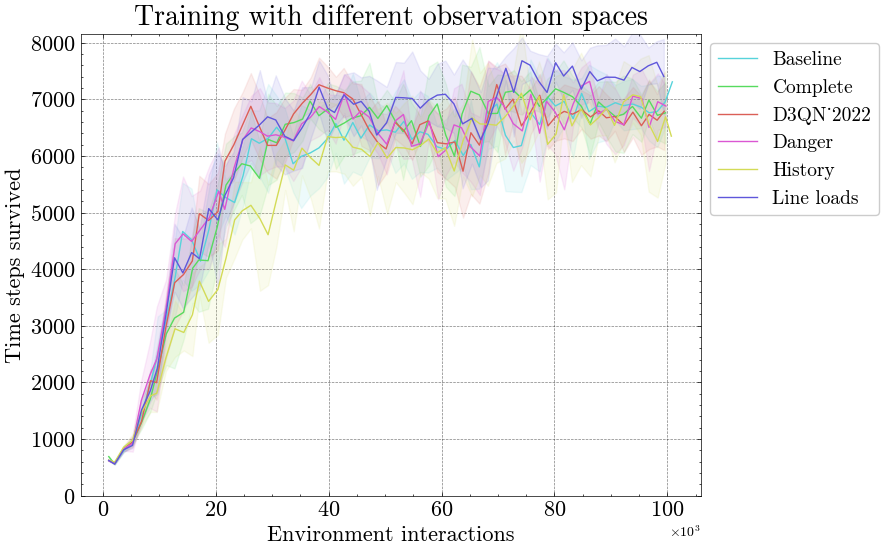

In [350]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_obs['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')

# plot 
plt = make_training_curve(df_obs, header="Training with different observation spaces", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_ObsSpaces.svg'))

In [246]:
project='OBS_OPPONENT'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/OBS_OPPONENT
Matching runs: 30


In [247]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_obs_opp = make_df_metrics(runs_Opp)
df_obs_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name
0,206,1,0,2,206,39305.914916,0,1115,Baseline
1,177,1,0,2,177,41045.014405,0,2197,Baseline
2,227,1,0,3,227,40382.894081,0,3281,Baseline
3,331,2,0,3,331,56638.261145,0,4341,Baseline
4,284,1,0,3,284,79204.594805,0,5381,Baseline
...,...,...,...,...,...,...,...,...,...
2782,496,3,0,5,496,136123.615554,2,94733,D3QN_2022
2783,446,3,0,4,446,89527.350239,1,95767,D3QN_2022
2784,445,3,0,3,445,91848.109098,0,96808,D3QN_2022
2785,354,2,0,3,354,69322.146692,0,97893,D3QN_2022


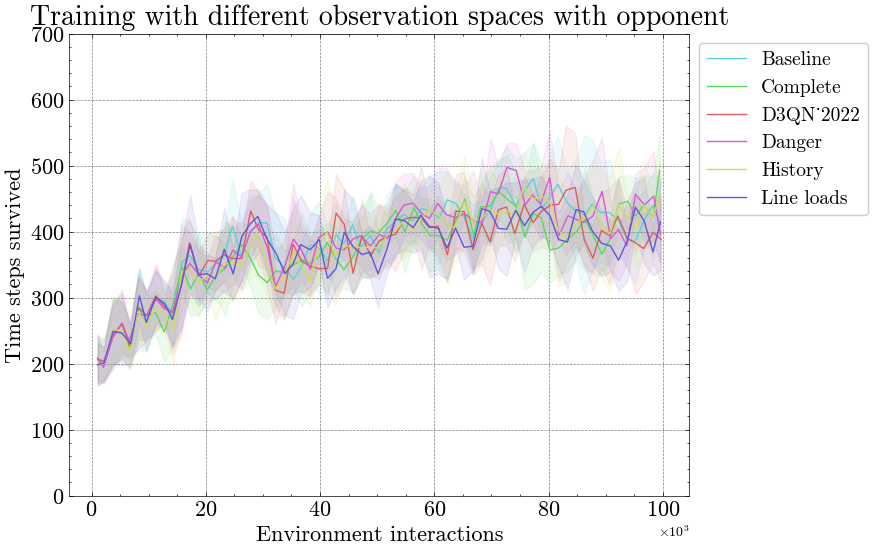

In [248]:
# Use LateX notations.
plt.rcParams['text.usetex'] = True
# plot 
plt = make_training_curve(df_obs_opp, header="Training with different observation spaces with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_ObsSpacesOpp.svg'))

In [143]:
agent_obs_spaces = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    # Set name = observation_space
    if run.config.get("env_config", {}).get("g2op_input") == "all":
        obs_space = "Complete"
    elif run.config.get("env_config", {}).get("g2op_input") == ["r"] or run.config.get("env_config", {}).get("g2op_input") == "r":
        obs_space = "Line loads"
    elif run.config.get("env_config", {}).get("n_history") == 6:
        obs_space = "History"
    elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
        obs_space = "Danger"
    elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "Baseline"
    elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "D3QN_2022"
    else:
        obs_space = ""
    data["observation space"] = obs_space
    agent_obs_spaces.append(data)

df_agent_obs_spaces = pd.DataFrame(agent_obs_spaces)
# df_agent_obs_spaces =df_agent_obs_spaces.sort_values(['observation space'], ascending=[True])
df_agent_obs_spaces.to_csv(os.path.join(path, "Obs_spaces_agent_ids.csv"), index=False)
df_agent_obs_spaces

,agent_id,observation space
0,CustomPPO_old_env_9405393_5e732,Danger
1,CustomPPO_old_env_9405344_a7981,Line loads
2,CustomPPO_old_env_9405597_65585,Complete
3,CustomPPO_old_env_9405342_ab255,Line loads
4,CustomPPO_old_env_9405346_ab0a9,Line loads
...,...,...
85,CustomPPO_old_env_9398580_7cbcd,Baseline
86,CustomPPO_old_env_9398576_7a291,Baseline
87,CustomPPO_old_env_9404845_381cb,Baseline
88,CustomPPO_old_env_9398579_742a5,Baseline


# Reward experiments

In [351]:
project='Case14_SurveyPaperRw'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperRw
Matching runs: 80


In [352]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        ep_rw = metrics_df['episode_reward_mean']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df['episode_reward'] = ep_rw
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = reward function
        # print(run.config.get("reward_fun", ""))
        if run.config.get("reward_fun", "") == "ScaledL2RPNReward":
            if run.config.get("env_config", {}).get("reward_finish"):
                rw_fun = "Base + Bonus/Penalty"
            else:
                rw_fun = "Baseline"   
        elif run.config.get("reward_fun", "") == "AlphaZeroRW":
            rw_fun = "AlphaZero" 
        elif run.config.get("reward_fun", "") == "RewardRho":
            rw_fun = "Binbinchen"
        elif run.config.get("reward_fun", "") == "LossReward":
            rw_fun = "SMAAC"
        elif run.config.get("reward_fun", "") == "ConstantReward":
            rw_fun = "Constant"            
        else:
            print("This reward function is not defined:", run.config.get("reward_fun", ""))
            rw_fun = ""
        metrics_df['name'] = rw_fun
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [353]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_rw = make_df_metrics(runs_NoOpp)
df_rw

,mean_interact_count,grid2op_end_std,mean_reset_count,mean_active_dn_count,grid2op_end_mean,mean_reconnect_count,corrected_ep_len_mean,mean_disconnect_count,env_interactions,episode_reward,name
0,2.917614,4.892728e+04,0,0.173295,614,0.000000,614,0,1027,24.157239,Baseline
1,2.972452,2.356962e+05,0,0.181818,590,0.013774,590,0,2106,53.378621,Baseline
2,3.062500,3.257949e+05,0,0.273810,804,0.000000,804,0,3135,40.536567,Baseline
3,3.559211,5.922907e+05,0,0.296053,800,0.000000,800,0,4217,124.108137,Baseline
4,4.218750,1.357251e+06,0,0.476562,1024,0.015625,1024,0,5297,277.079375,Baseline
...,...,...,...,...,...,...,...,...,...,...,...
2752,3.801471,5.996056e+06,0,0.327206,6670,0.000000,6670,0,95507,4800.689259,AlphaZero
2753,3.631579,2.491814e+06,0,0.355263,7531,0.000000,7531,0,96611,5412.192783,AlphaZero
2754,3.516447,4.612751e+06,0,0.361842,7117,0.000000,7117,0,97680,5043.672132,AlphaZero
2755,4.179688,2.594192e+06,0,0.476562,7110,0.000000,7110,0,98750,5006.640463,AlphaZero


In [261]:
df_rw.columns

Index(['mean_interact_count', 'grid2op_end_std', 'mean_reset_count',
       'mean_active_dn_count', 'grid2op_end_mean', 'mean_reconnect_count',
       'corrected_ep_len_mean', 'mean_disconnect_count', 'env_interactions',
       'episode_reward', 'name'],
      dtype='object')

In [262]:
df_rw['name'].unique()

array(['Baseline', 'Binbinchen', 'Base + Bonus/Penalty', 'Constant',
       'AlphaZero', 'SMAAC'], dtype=object)

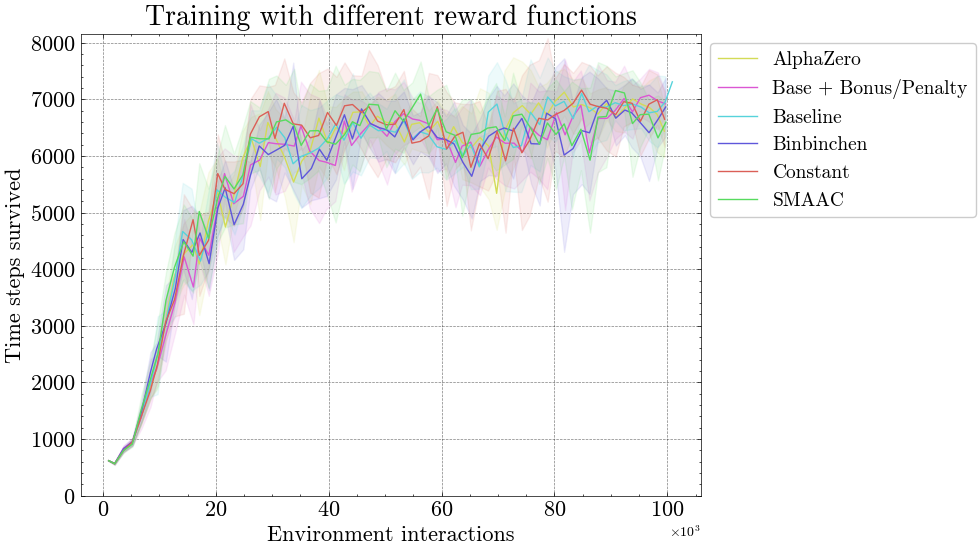

In [354]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_rw['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')

# plot 
plt = make_training_curve(df_rw, header="Training with different reward functions", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_RW.svg'))

In [264]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_rw_opp = make_df_metrics(runs_Opp)
df_rw_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,episode_reward,name
0,206,1,0,2,206,39305.914916,0,1115,11.935315,Baseline
1,177,1,0,2,177,41045.014405,0,2197,27.621292,Baseline
2,227,1,0,3,227,40382.894081,0,3281,16.721220,Baseline
3,331,2,0,3,331,56638.261145,0,4341,37.784320,Baseline
4,284,1,0,3,284,79204.594805,0,5381,30.627781,Baseline
...,...,...,...,...,...,...,...,...,...,...
2766,402,2,0,3,402,92907.972974,0,95172,243.676157,Constant
2767,415,2,0,4,415,62568.843414,1,96229,239.325581,Constant
2768,478,3,0,5,478,48077.775184,1,97320,282.875000,Constant
2769,459,3,0,5,459,109674.028775,2,98398,244.450000,Constant


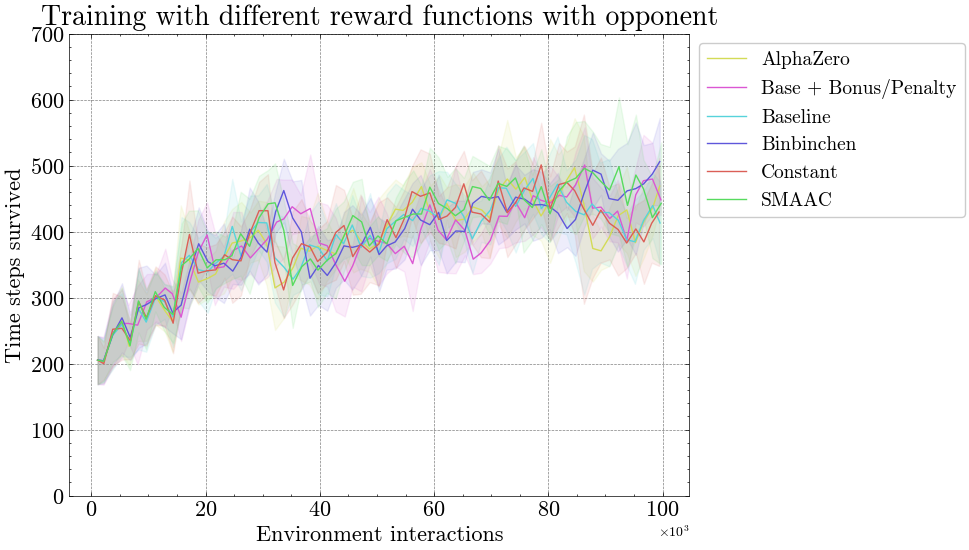

In [265]:
# plot 
plt = make_training_curve(df_rw_opp, header="Training with different reward functions with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_RwOpp.svg'))

In [266]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_reward_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'episode_reward': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="env_interactions",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    # plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Episode reward', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

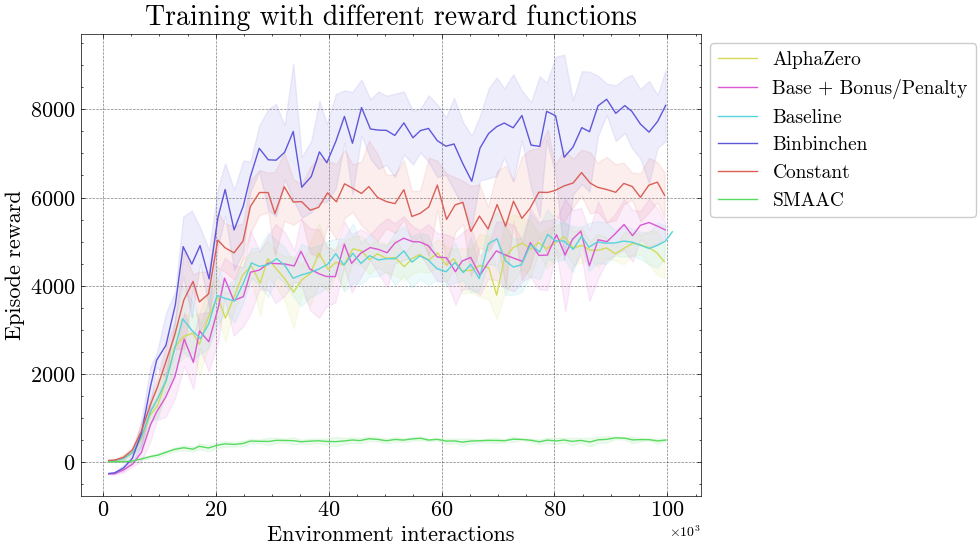

In [355]:
# plot 
plt = make_reward_curve(df_rw, header="Training with different reward functions", palette=fixed_palette)
plt.savefig(os.path.join(path, f'RewardCurve_RW.svg'))

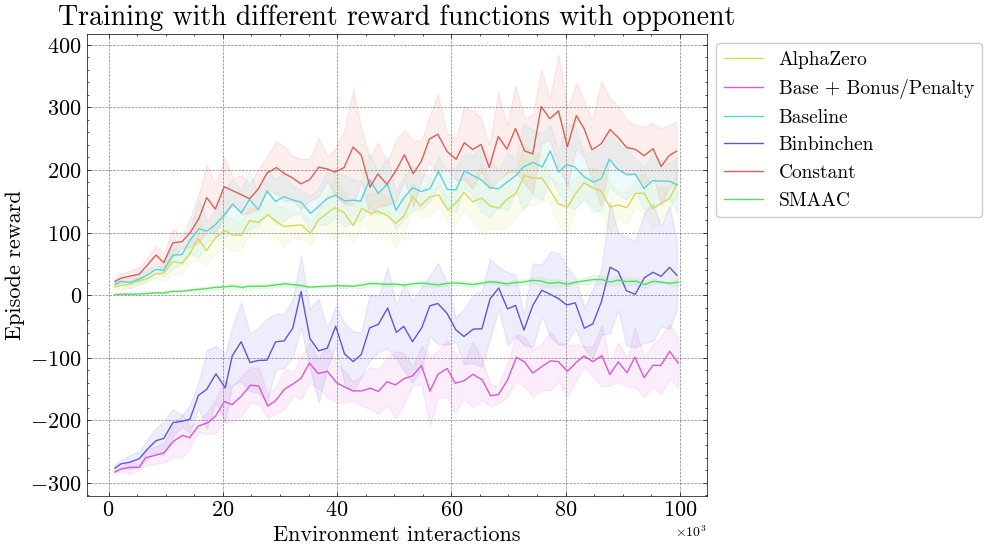

In [268]:
# plot 
plt = make_reward_curve(df_rw_opp, header="Training with different reward functions with opponent", palette=fixed_palette)
plt.savefig(os.path.join(path, f'RewardCurve_RWOpp.svg'))

# Activation Threshold Experiments

In [356]:
project='Case14_SurveyPaperAT'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperAT
Matching runs: 50


In [357]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = reward function
        metrics_df['name'] = "$\\rho_{thresh}$: " + str(run.config.get("env_config", {}).get("rho_threshold"))
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [358]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_at = make_df_metrics(runs_NoOpp)
df_at

,mean_interact_count,grid2op_end_std,mean_reset_count,mean_active_dn_count,grid2op_end_mean,mean_reconnect_count,corrected_ep_len_mean,mean_disconnect_count,env_interactions,name
0,2.917614,4.892728e+04,0,0.173295,614,0.000000,614,0,1027,$\rho_{thresh}$: 0.95
1,2.972452,2.356962e+05,0,0.181818,590,0.013774,590,0,2106,$\rho_{thresh}$: 0.95
2,3.062500,3.257949e+05,0,0.273810,804,0.000000,804,0,3135,$\rho_{thresh}$: 0.95
3,3.559211,5.922907e+05,0,0.296053,800,0.000000,800,0,4217,$\rho_{thresh}$: 0.95
4,4.218750,1.357251e+06,0,0.476562,1024,0.015625,1024,0,5297,$\rho_{thresh}$: 0.95
...,...,...,...,...,...,...,...,...,...,...
1583,3.065476,7.063575e+05,0,0.431548,7892,0.005952,7892,0,95347,$\rho_{thresh}$: 0.99
1584,2.731771,3.018846e+05,0,0.299479,7954,0.000000,7954,0,96396,$\rho_{thresh}$: 0.99
1585,2.647500,2.485523e+05,0,0.265000,7978,0.000000,7978,0,97455,$\rho_{thresh}$: 0.99
1586,3.065476,3.163229e+05,0,0.398810,7987,0.017857,7987,0,98485,$\rho_{thresh}$: 0.99


In [273]:
df_at.name.unique()

array(['$\\rho_{thresh}$: 0.95', '$\\rho_{thresh}$: 0.8',
       '$\\rho_{thresh}$: 0.9', '$\\rho_{thresh}$: 0.99'], dtype=object)

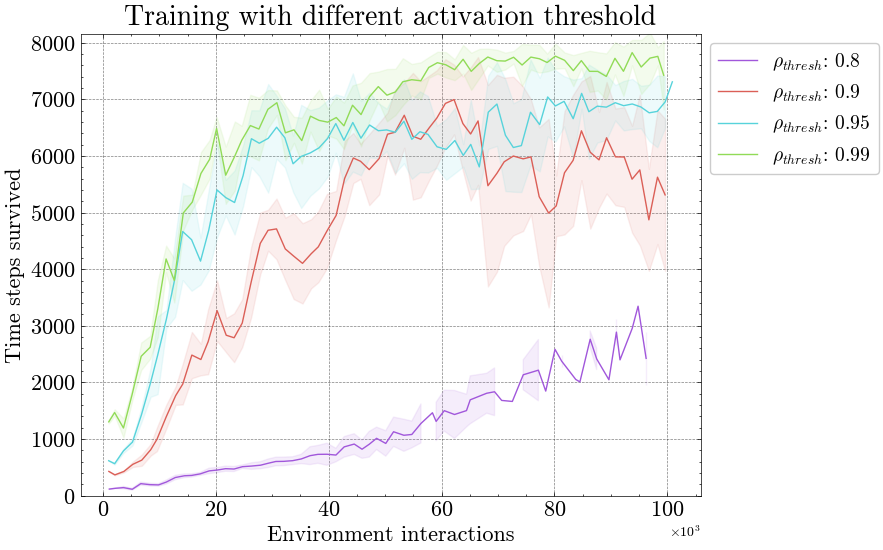

In [359]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_at['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='$\\rho_{thresh}$: 0.95')

# plot 
plt = make_training_curve(df_at, header="Training with different activation threshold", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_AT.svg'))

In [275]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_at_opp = make_df_metrics(runs_Opp)
df_at_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name
0,206,1,0,2,206,39305.914916,0,1115,$\rho_{thresh}$: 0.95
1,177,1,0,2,177,41045.014405,0,2197,$\rho_{thresh}$: 0.95
2,227,1,0,3,227,40382.894081,0,3281,$\rho_{thresh}$: 0.95
3,331,2,0,3,331,56638.261145,0,4341,$\rho_{thresh}$: 0.95
4,284,1,0,3,284,79204.594805,0,5381,$\rho_{thresh}$: 0.95
...,...,...,...,...,...,...,...,...,...
1832,587,4,0,3,587,167278.252804,0,95005,$\rho_{thresh}$: 0.99
1833,426,2,0,2,426,110700.932963,0,96050,$\rho_{thresh}$: 0.99
1834,491,3,0,3,491,232539.349787,0,97135,$\rho_{thresh}$: 0.99
1835,610,4,0,3,610,262326.754661,0,98199,$\rho_{thresh}$: 0.99


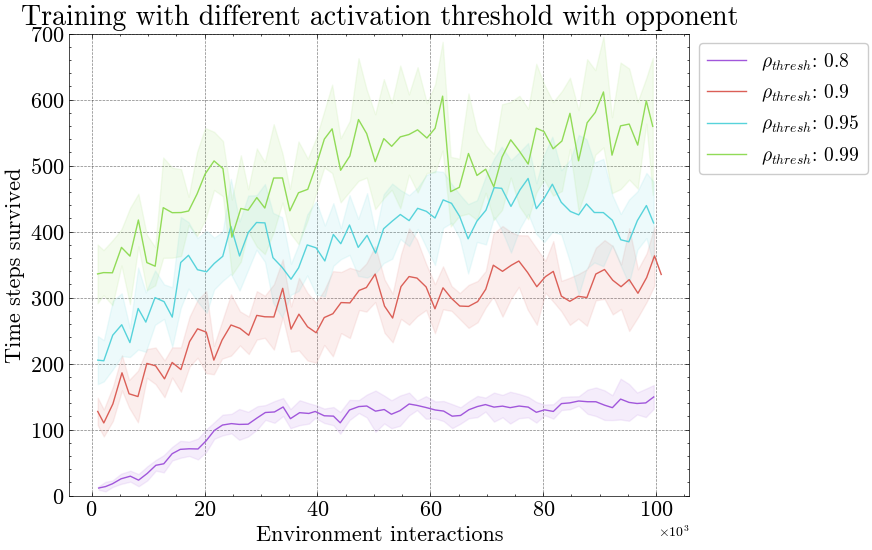

In [276]:
# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_at_opp, header="Training with different activation threshold with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_AT_Opp.svg'))

# Line switching experiments

In [368]:
project='Case14_SurveyPaperLine'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperLine
Matching runs: 35


In [369]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name 
        reco = str(True if run.config.get("env_config", {}).get("line_reco") is None else run.config.get("env_config", {}).get("line_reco"))
        disc = str(False if run.config.get("env_config", {}).get("line_disc") is None else run.config.get("env_config", {}).get("line_disc"))
        metrics_df['name'] = f"Reconnection: {reco}, Disconnection: {disc}"
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [370]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_line = make_df_metrics(runs_NoOpp)
df_line

,mean_interact_count,grid2op_end_std,mean_reset_count,mean_active_dn_count,grid2op_end_mean,mean_reconnect_count,corrected_ep_len_mean,mean_disconnect_count,env_interactions,name
0,2.917614,4.892728e+04,0,0.173295,614,0.000000,614,0.0,1027,"Reconnection: True, Disconnection: False"
1,2.972452,2.356962e+05,0,0.181818,590,0.013774,590,0.0,2106,"Reconnection: True, Disconnection: False"
2,3.062500,3.257949e+05,0,0.273810,804,0.000000,804,0.0,3135,"Reconnection: True, Disconnection: False"
3,3.559211,5.922907e+05,0,0.296053,800,0.000000,800,0.0,4217,"Reconnection: True, Disconnection: False"
4,4.218750,1.357251e+06,0,0.476562,1024,0.015625,1024,0.0,5297,"Reconnection: True, Disconnection: False"
...,...,...,...,...,...,...,...,...,...,...
1373,12.510000,3.323386e+06,0,5.980000,7321,0.000000,7321,0.0,93671,"Reconnection: False, Disconnection: False"
1374,11.142857,4.656186e+05,0,5.857143,7999,0.000000,7999,0.0,94919,"Reconnection: False, Disconnection: False"
1375,13.070000,1.454713e+06,0,8.000000,7691,0.000000,7691,0.0,96168,"Reconnection: False, Disconnection: False"
1376,11.920000,1.991036e+06,0,5.530000,7479,0.000000,7479,0.0,97316,"Reconnection: False, Disconnection: False"


In [280]:
df_line.name.unique()

array(['Reconnection: True, Disconnection: False',
       'Reconnection: False, Disconnection: False',
       'Reconnection: True, Disconnection: True'], dtype=object)

In [290]:
sns.color_palette("hls", 3)

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.3712, 0.33999999999999997, 0.86)]

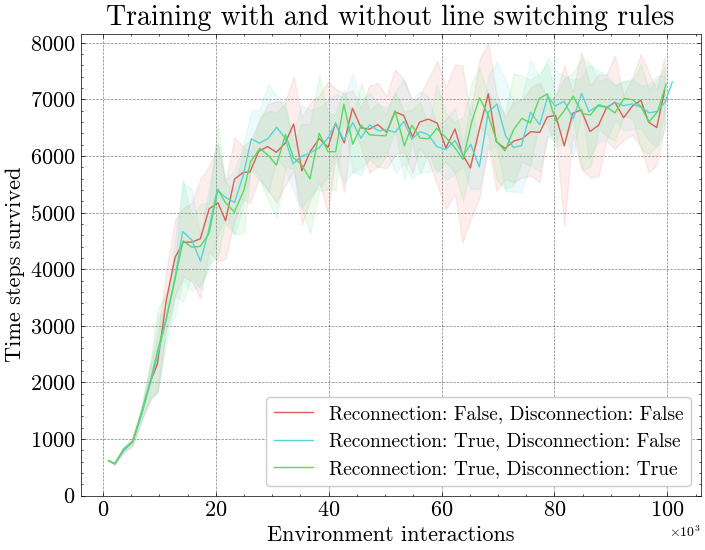

In [371]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_line['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Reconnection: True, Disconnection: False')

# plot 
plt = make_training_curve(df_line, header="Training with and without line switching rules", palette=fixed_palette)
plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_Line.svg'))

In [296]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_line_opp = make_df_metrics(runs_Opp)
df_line_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name,mean_disconnect_count
0,206,1,0,2,206,39305.914916,0,1115,"Reconnection: True, Disconnection: False",NaN
1,177,1,0,2,177,41045.014405,0,2197,"Reconnection: True, Disconnection: False",NaN
2,227,1,0,3,227,40382.894081,0,3281,"Reconnection: True, Disconnection: False",NaN
3,331,2,0,3,331,56638.261145,0,4341,"Reconnection: True, Disconnection: False",NaN
4,284,1,0,3,284,79204.594805,0,5381,"Reconnection: True, Disconnection: False",NaN
...,...,...,...,...,...,...,...,...,...,...
1384,468,3,0,4,468,214144.721462,1,95322,"Reconnection: True, Disconnection: True",0.0
1385,373,2,0,3,373,137126.509633,0,96353,"Reconnection: True, Disconnection: True",0.0
1386,353,2,0,3,353,92462.468100,0,97448,"Reconnection: True, Disconnection: True",0.0
1387,374,2,0,3,374,97048.356279,0,98515,"Reconnection: True, Disconnection: True",0.0


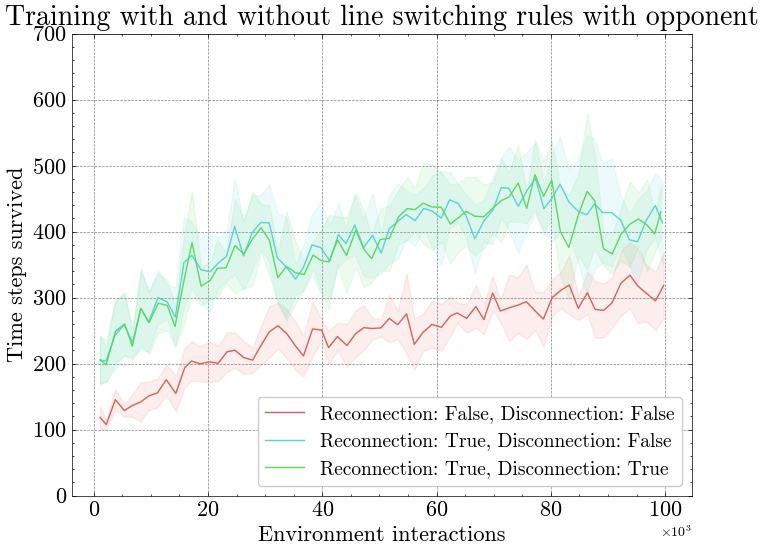

In [297]:
# plot 
plt = make_training_curve(df_line_opp, header="Training with and without line switching rules with opponent", palette=fixed_palette, max_env_steps=600)
plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_LineOpp.svg'))

# Revert Topo Experiments

In [360]:
project='Case14_SurveyPaperReset'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperReset
Matching runs: 50


In [361]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name
        rt = run.config.get("env_config", {}).get("reset_topo")
        reset_topo = "No RT" if rt==0 else ("RT: " + str(rt))
        metrics_df['name'] = reset_topo
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [362]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_rt = make_df_metrics(runs_NoOpp)
df_rt

,mean_reconnect_count,mean_disconnect_count,mean_active_dn_count,grid2op_end_std,mean_interact_count,corrected_ep_len_mean,grid2op_end_mean,mean_reset_count,env_interactions,name
0,0.008152,0,0.133152,5.341887e+04,2.858696,630,630,0.078804,1052,RT: 0.95
1,0.011494,0,0.206897,2.628931e+05,3.017241,589,589,0.132184,2102,RT: 0.95
2,0.003125,0,0.250000,3.867955e+05,3.246875,848,848,0.131250,3141,RT: 0.95
3,0.013889,0,0.256944,1.726085e+06,3.593750,962,962,0.173611,4176,RT: 0.95
4,0.008333,0,0.370833,1.961636e+06,4.275000,1175,1175,0.337500,5202,RT: 0.95
...,...,...,...,...,...,...,...,...,...,...
1790,0.000000,0,0.971154,4.151464e+06,5.096154,7088,7088,0.000000,95453,No RT
1791,0.000000,0,0.855769,2.996673e+06,4.971154,6997,6997,0.000000,96487,No RT
1792,0.004167,0,0.520833,4.910929e+06,4.395833,6530,6530,0.000000,97542,No RT
1793,0.000000,0,0.973214,2.332269e+06,4.816964,7481,7481,0.000000,98621,No RT


In [301]:
df_rt['name'].unique()

array(['No RT', 'RT: 0.95', 'RT: 0.9', 'RT: 0.8'], dtype=object)

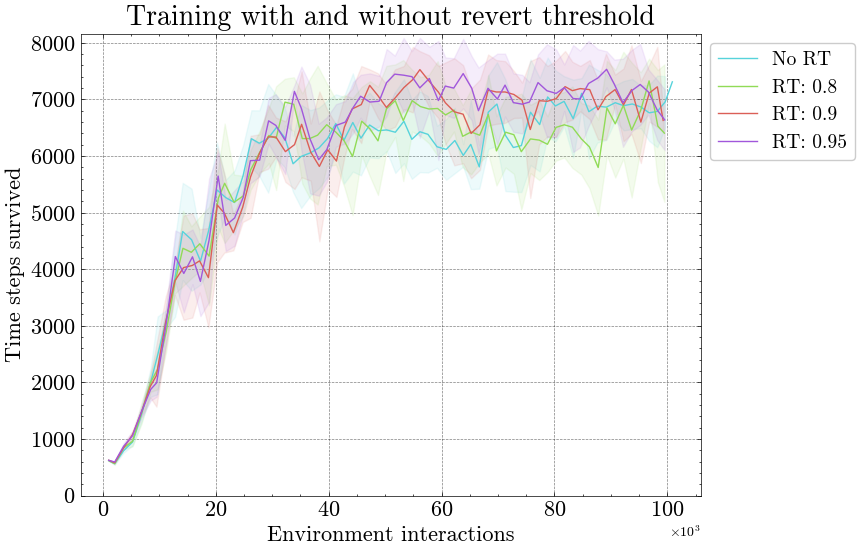

In [363]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_rt['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='No RT')

# plot 
plt = make_training_curve(df_rt, header="Training with and without revert threshold", palette=fixed_palette)
# plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_RT.svg'))

In [303]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_rt_opp = make_df_metrics(runs_Opp)
df_rt_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name,mean_disconnect_count
0,206,1,0,2,206,39305.914916,0,1115,No RT,NaN
1,177,1,0,2,177,41045.014405,0,2197,No RT,NaN
2,227,1,0,3,227,40382.894081,0,3281,No RT,NaN
3,331,2,0,3,331,56638.261145,0,4341,No RT,NaN
4,284,1,0,3,284,79204.594805,0,5381,No RT,NaN
...,...,...,...,...,...,...,...,...,...,...
1855,381,2,0,4,381,89576.352889,1,95212,RT: 0.9,0.0
1856,417,2,0,5,417,96974.496489,1,96254,RT: 0.9,0.0
1857,425,2,0,4,425,75800.896503,1,97297,RT: 0.9,0.0
1858,488,3,0,4,488,166090.582659,1,98348,RT: 0.9,0.0


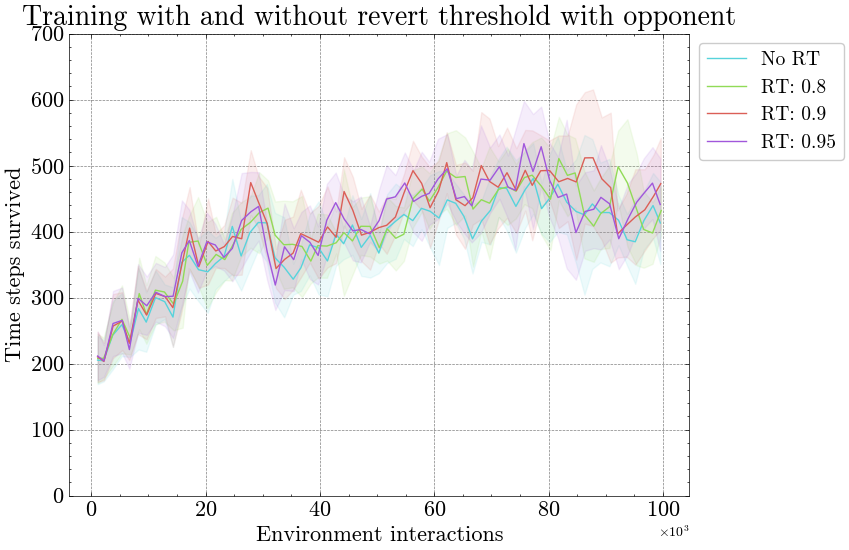

In [304]:
# plot 
plt = make_training_curve(df_rt_opp, header="Training with and without revert threshold with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_RTOpp.svg'))

# Curriculum training

In [364]:
project='Case14_SurveyPaperCurr'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperCurr
Matching runs: 45


In [365]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name
        curr = run.config.get("env_config", {}).get("curriculum_training", False)
        if curr:
            thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
            if thresholds == [20000,46667]:
                curriculum_training = "Curriculum"
            else:
                continue
        else:
            curriculum_training = "Baseline"
        metrics_df['name'] = curriculum_training        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [366]:
runs_NoOpp = [run for run in runs if run.config.get('num_sgd_iter')==5 and not run.config.get('opponent')]
df_curr = make_df_metrics(runs_NoOpp)
df_curr

,corrected_ep_len_mean,mean_reset_count,mean_reconnect_count,mean_disconnect_count,mean_active_dn_count,mean_interact_count,grid2op_end_std,grid2op_end_mean,env_interactions,name
0,722,0,0.000000,0,0.678571,9.705357,2.702314e+04,722,1087,Curriculum
1,613,0,0.000000,0,0.570312,8.500000,1.920387e+05,613,2175,Curriculum
2,634,0,0.000000,0,0.714286,9.508929,6.108609e+04,634,3240,Curriculum
3,854,0,0.000000,0,0.920000,10.920000,8.131415e+05,854,4293,Curriculum
4,773,0,0.000000,0,1.165049,11.359223,1.037136e+06,773,5463,Curriculum
...,...,...,...,...,...,...,...,...,...,...
890,7088,0,0.000000,0,0.971154,5.096154,4.151464e+06,7088,95453,Baseline
891,6997,0,0.000000,0,0.855769,4.971154,2.996673e+06,6997,96487,Baseline
892,6530,0,0.004167,0,0.520833,4.395833,4.910929e+06,6530,97542,Baseline
893,7481,0,0.000000,0,0.973214,4.816964,2.332269e+06,7481,98621,Baseline


In [321]:
df_curr['name'].unique()

array(['No curriculum levels', 'Level 1: 20000, level 2: 46667'],
      dtype=object)

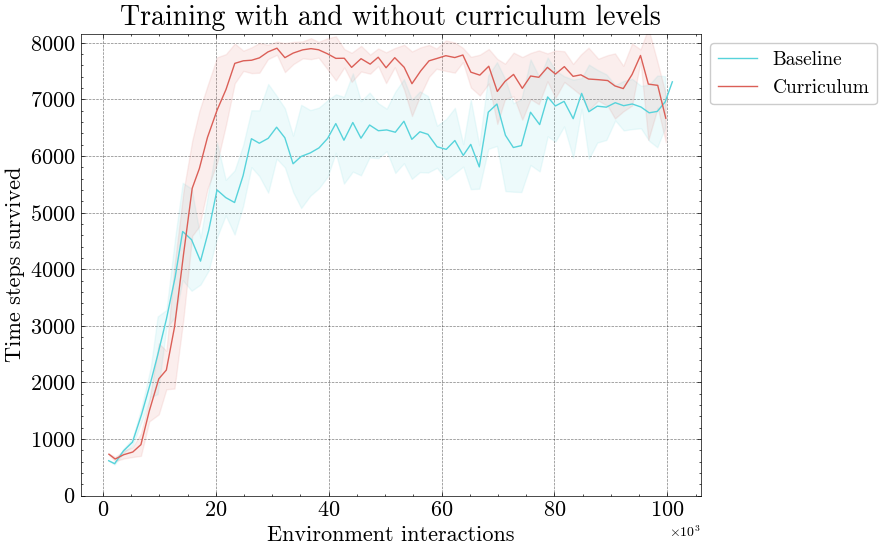

In [372]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_curr['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')

# plot 
plt = make_training_curve(df_curr, header="Training with and without curriculum levels", palette=fixed_palette)
# plt.legend(fontsize=14, loc='lower right')
plt.savefig(os.path.join(path, f'Traincurve_Curr.svg'))

In [327]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_curr_opp = make_df_metrics(runs_Opp)
df_curr_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name,mean_disconnect_count
0,206,1.00,0,2.00,206,39305.914916,0.00,1115,Baseline,NaN
1,177,1.00,0,2.00,177,41045.014405,0.00,2197,Baseline,NaN
2,227,1.00,0,3.00,227,40382.894081,0.00,3281,Baseline,NaN
3,331,2.00,0,3.00,331,56638.261145,0.00,4341,Baseline,NaN
4,284,1.00,0,3.00,284,79204.594805,0.00,5381,Baseline,NaN
...,...,...,...,...,...,...,...,...,...,...
869,551,3.47,0,19.71,551,157432.257100,4.69,94607,Curriculum,0.0
870,491,3.14,0,17.33,491,122832.537900,3.24,95705,Curriculum,0.0
871,551,3.65,0,17.71,551,132499.406400,4.00,96986,Curriculum,0.0
872,488,3.27,0,19.74,488,95220.301900,4.20,98082,Curriculum,0.0


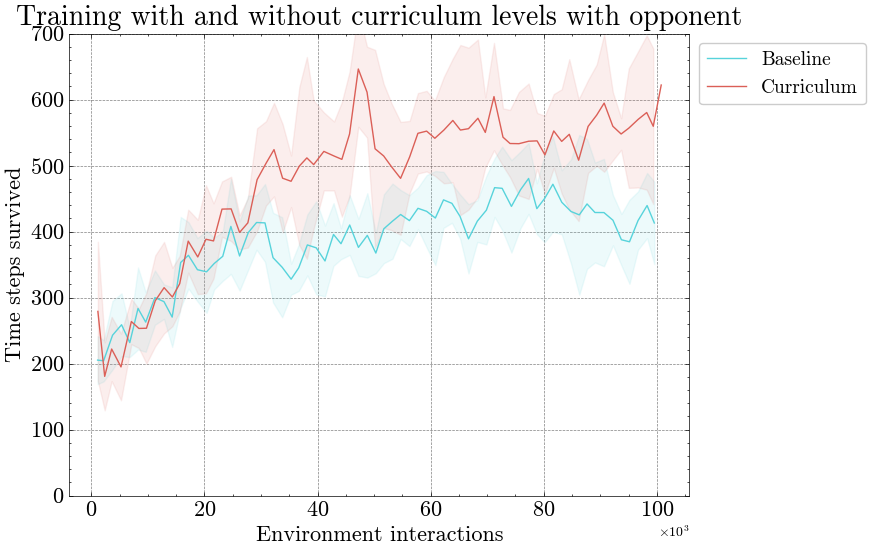

In [329]:
# Define all possible names and assign fixed colors
all_names = df_curr_opp['name'].unique()
fixed_palette = make_color_dict(all_names, baseline_name='Baseline')
# plot 
plt = make_training_curve(df_curr_opp, header="Training with and without curriculum levels with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_CurrOpp.svg'))

In [317]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==15 and not run.config.get('opponent'):
        # Skip this agent -> wrong configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training     
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "curr_agent_ids.csv"), index=False)
df_agent_curriculum

,agent_id,curriculum training
0,CustomPPO_old_env_9398580_7cbcd,No curriculum levels
1,CustomPPO_old_env_9398576_7a291,No curriculum levels
2,CustomPPO_old_env_9398578_766ba,No curriculum levels
3,CustomPPO_old_env_9398579_742a5,No curriculum levels
4,CustomPPO_old_env_9398577_75848,No curriculum levels
5,CustomPPO_old_env_9779113_241ce,"Level 1: 30000, level 2: 60000"
6,CustomPPO_old_env_9779114_26d44,"Level 1: 30000, level 2: 60000"
7,CustomPPO_old_env_9779112_25e7f,"Level 1: 30000, level 2: 60000"
8,CustomPPO_old_env_9779107_25f78,"Level 1: 30000, level 2: 60000"
9,CustomPPO_old_env_9779115_277c8,"Level 1: 30000, level 2: 60000"


In [318]:
agent_curr_levels = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    if run.config.get('num_sgd_iter')==5 or run.config.get('opponent'):
        # Skip this agent -> correct configuration.
        continue
    
    # Set name = curriculum training
    curr = run.config.get("env_config", {}).get("curriculum_training", False)
    if curr:
        thresholds = run.config.get("env_config", {}).get("curriculum_thresholds", [0,0])
        curriculum_training = f"Level 1: {thresholds[0]}, level 2: {thresholds[1]}"
    else:
        curriculum_training = "No curriculum levels"
    data['curriculum training'] = curriculum_training     
    
    agent_curr_levels.append(data)

df_agent_curriculum = pd.DataFrame(agent_curr_levels)
df_agent_curriculum.to_csv(os.path.join(path, "curr_agent_ids_WRONGPPO.csv"), index=False)
df_agent_curriculum

,agent_id,curriculum training
0,CustomPPO_old_env_9779096_fc9e4,"Level 1: 30000, level 2: 60000"
1,CustomPPO_old_env_9779097_fc976,"Level 1: 30000, level 2: 60000"
2,CustomPPO_old_env_9779091_f3314,"Level 1: 30000, level 2: 60000"
3,CustomPPO_old_env_9779095_fc976,"Level 1: 30000, level 2: 60000"
4,CustomPPO_old_env_9779098_fc976,"Level 1: 30000, level 2: 60000"
5,CustomPPO_old_env_9791472_aab71,"Level 1: 25000, level 2: 50000"
6,CustomPPO_old_env_9791469_b68a9,"Level 1: 25000, level 2: 50000"
7,CustomPPO_old_env_9791473_b68f2,"Level 1: 25000, level 2: 50000"
8,CustomPPO_old_env_9791474_b68a9,"Level 1: 25000, level 2: 50000"
9,CustomPPO_old_env_9791471_aaba1,"Level 1: 25000, level 2: 50000"
